# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). 

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification


The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>

\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}

<br>


# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>  
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
    
    
    
    
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Enter data folder location
loc = "/content/drive/MyDrive/Master's/multi/project/MEx"

In [3]:
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...
1,04,01,1,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...
2,04,05,1,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...
3,04,03,1,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...
4,04,02,1,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...


Dataframe with one measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,...,dc_152,dc_153,dc_154,dc_155,dc_156,dc_157,dc_158,dc_159,dc_160,dc_161,dc_162,dc_163,dc_164,dc_165,dc_166,dc_167,dc_168,dc_169,dc_170,dc_171,dc_172,dc_173,dc_174,dc_175,dc_176,dc_177,dc_178,dc_179,dc_180,dc_181,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4497,0.9181,0.9111,0.915,0.9244,0.9189,0.914,0.9105,0.9088,0.9025,0.8994,0.8939,0.8884,0.8846,0.8846,0.8799,0.4435,0.9121,0.9306,0.9306,0.9283,0.9244,0.9056,0.9131,0.9094,0.9088,0.9025,0.8994,0.8963,0.8884,0.8846,0.8814,0.4429,0.9100,0.9337,0.9290,0.9244,0.9212,0.9165,...,0.7110,0.7001,0.7149,0.7325,0.9244,0.9244,0.9181,0.9121,0.4936,0.9782,0.9751,0.9680,0.9641,0.961,0.9555,0.9501,0.947,0.7079,0.7276,0.2326,0.9322,0.9244,0.9236,0.9165,0.4945,0.9829,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9415,0.9368,0.9337,0.9306,0.9228,0.9220
1,1000.0,0.4497,0.9181,0.9111,0.915,0.9212,0.9181,0.914,0.9111,0.9088,0.9025,0.8994,0.8931,0.8884,0.8846,0.8814,0.8806,0.4435,0.9121,0.9306,0.9306,0.9283,0.9244,0.9064,0.9121,0.9100,0.9080,0.9025,0.8994,0.8963,0.8869,0.8846,0.8814,0.4435,0.9100,0.9337,0.9275,0.9244,0.9212,0.9173,...,0.6644,0.6389,0.6377,0.6482,0.0000,0.9244,0.9181,0.9150,0.4945,0.9782,0.9751,0.9688,0.9641,0.961,0.9555,0.9501,0.947,0.9447,0.6404,0.6459,0.9306,0.9267,0.9244,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9431,0.9368,0.9337,0.9306,0.9244,0.9236
2,2000.0,0.4497,0.9173,0.9111,0.915,0.9220,0.9197,0.914,0.9111,0.9088,0.9025,0.8994,0.8931,0.8884,0.8838,0.8814,0.8814,0.4435,0.9121,0.9306,0.9306,0.9298,0.9220,0.9072,0.9121,0.9100,0.9080,0.9025,0.8994,0.4830,0.6667,0.8846,0.8814,0.4423,0.9100,0.9329,0.9306,0.7270,0.3491,0.6732,...,0.9439,0.8083,0.8089,0.9306,0.9244,0.9244,0.9181,0.9150,0.4926,0.9782,0.9751,0.9696,0.9641,0.961,0.9555,0.9501,0.947,0.9439,0.7026,0.9337,0.9306,0.9260,0.9244,0.9165,0.4945,0.9836,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9431,0.9368,0.9337,0.9314,0.9220,0.9220
3,3000.0,0.4497,0.9197,0.9111,0.915,0.9212,0.9189,0.914,0.9111,0.9088,0.9025,0.8994,0.8939,0.4435,0.8822,0.8814,0.8814,0.4429,0.9131,0.9306,0.9283,0.9298,0.9220,0.9064,0.9131,0.9111,0.5378,0.5021,0.4772,0.4618,0.4629,0.0000,0.8814,0.4423,0.9111,0.9329,0.9298,0.7227,0.6993,0.6759,...,0.9439,0.8031,0.8060,0.9306,0.9260,0.9244,0.9197,0.9140,0.4926,0.9782,0.9751,0.9688,0.9641,0.961,0.9555,0.9501,0.947,0.9439,0.9360,0.9337,0.9322,0.9252,0.9236,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9415,0.9368,0.9337,0.9306,0.9236,0.9236
4,4000.0,0.4497,0.9181,0.9111,0.915,0.9212,0.9181,0.914,0.9111,0.9088,0.9025,0.9017,0.8939,0.8884,0.8846,0.8814,0.8799,0.4435,0.9115,0.9306,0.9298,0.9298,0.9244,0.9072,0.9131,0.9105,0.9088,0.9025,0.8994,0.8963,0.8869,0.8838,0.8814,0.4423,0.9100,0.9329,0.9275,0.9244,0.9212,0.9165,...,0.9447,0.6040,0.5757,0.5734,0.1517,0.9244,0.9181,0.9121,0.4918,0.9782,0.9751,0.9680,0.9641,0.961,0.9555,0.9493,0.947,0.9439,0.6034,0.5913,0.9314,0.9260,0.9244,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9423,0.9368,0.9337,0.9306,0.9228,0.9220


In [4]:
# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_188...,0
1,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_188...,1
2,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_188...,2
3,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...,3
4,04,04,2,dc,dc,time dc_0 dc_1 dc_2 ... dc_1...,4


Dataframe with one windowed measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,...,dc_152,dc_153,dc_154,dc_155,dc_156,dc_157,dc_158,dc_159,dc_160,dc_161,dc_162,dc_163,dc_164,dc_165,dc_166,dc_167,dc_168,dc_169,dc_170,dc_171,dc_172,dc_173,dc_174,dc_175,dc_176,dc_177,dc_178,dc_179,dc_180,dc_181,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4497,0.9181,0.9111,0.915,0.9244,0.9189,0.914,0.9105,0.9088,0.9025,0.8994,0.8939,0.8884,0.8846,0.8846,0.8799,0.4435,0.9121,0.9306,0.9306,0.9283,0.9244,0.9056,0.9131,0.9094,0.9088,0.9025,0.8994,0.8963,0.8884,0.8846,0.8814,0.4429,0.9100,0.9337,0.9290,0.9244,0.9212,0.9165,...,0.7110,0.7001,0.7149,0.7325,0.9244,0.9244,0.9181,0.9121,0.4936,0.9782,0.9751,0.9680,0.9641,0.961,0.9555,0.9501,0.947,0.7079,0.7276,0.2326,0.9322,0.9244,0.9236,0.9165,0.4945,0.9829,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9415,0.9368,0.9337,0.9306,0.9228,0.9220
1,1000.0,0.4497,0.9181,0.9111,0.915,0.9212,0.9181,0.914,0.9111,0.9088,0.9025,0.8994,0.8931,0.8884,0.8846,0.8814,0.8806,0.4435,0.9121,0.9306,0.9306,0.9283,0.9244,0.9064,0.9121,0.9100,0.9080,0.9025,0.8994,0.8963,0.8869,0.8846,0.8814,0.4435,0.9100,0.9337,0.9275,0.9244,0.9212,0.9173,...,0.6644,0.6389,0.6377,0.6482,0.0000,0.9244,0.9181,0.9150,0.4945,0.9782,0.9751,0.9688,0.9641,0.961,0.9555,0.9501,0.947,0.9447,0.6404,0.6459,0.9306,0.9267,0.9244,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9431,0.9368,0.9337,0.9306,0.9244,0.9236
2,2000.0,0.4497,0.9173,0.9111,0.915,0.9220,0.9197,0.914,0.9111,0.9088,0.9025,0.8994,0.8931,0.8884,0.8838,0.8814,0.8814,0.4435,0.9121,0.9306,0.9306,0.9298,0.9220,0.9072,0.9121,0.9100,0.9080,0.9025,0.8994,0.4830,0.6667,0.8846,0.8814,0.4423,0.9100,0.9329,0.9306,0.7270,0.3491,0.6732,...,0.9439,0.8083,0.8089,0.9306,0.9244,0.9244,0.9181,0.9150,0.4926,0.9782,0.9751,0.9696,0.9641,0.961,0.9555,0.9501,0.947,0.9439,0.7026,0.9337,0.9306,0.9260,0.9244,0.9165,0.4945,0.9836,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9431,0.9368,0.9337,0.9314,0.9220,0.9220
3,3000.0,0.4497,0.9197,0.9111,0.915,0.9212,0.9189,0.914,0.9111,0.9088,0.9025,0.8994,0.8939,0.4435,0.8822,0.8814,0.8814,0.4429,0.9131,0.9306,0.9283,0.9298,0.9220,0.9064,0.9131,0.9111,0.5378,0.5021,0.4772,0.4618,0.4629,0.0000,0.8814,0.4423,0.9111,0.9329,0.9298,0.7227,0.6993,0.6759,...,0.9439,0.8031,0.8060,0.9306,0.9260,0.9244,0.9197,0.9140,0.4926,0.9782,0.9751,0.9688,0.9641,0.961,0.9555,0.9501,0.947,0.9439,0.9360,0.9337,0.9322,0.9252,0.9236,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9415,0.9368,0.9337,0.9306,0.9236,0.9236
4,4000.0,0.4497,0.9181,0.9111,0.915,0.9212,0.9181,0.914,0.9111,0.9088,0.9025,0.9017,0.8939,0.8884,0.8846,0.8814,0.8799,0.4435,0.9115,0.9306,0.9298,0.9298,0.9244,0.9072,0.9131,0.9105,0.9088,0.9025,0.8994,0.8963,0.8869,0.8838,0.8814,0.4423,0.9100,0.9329,0.9275,0.9244,0.9212,0.9165,...,0.9447,0.6040,0.5757,0.5734,0.1517,0.9244,0.9181,0.9121,0.4918,0.9782,0.9751,0.9680,0.9641,0.961,0.9555,0.9493,0.947,0.9439,0.6034,0.5913,0.9314,0.9260,0.9244,0.9165,0.4945,0.9821,0.9751,0.9751,0.9704,0.961,0.961,0.954,0.9501,0.947,0.9423,0.9368,0.9337,0.9306,0.9228,0.9220


In [5]:
df_records_windowed.drop(['sensor_code', 'trial'], axis=1, inplace=True)

## Helper functions

In [6]:
def extract(p, e):
  p1_2 = df_records_windowed[df_records_windowed['subject_id'] == p]
  p1_2 = p1_2[p1_2['exercise_id'] == e]
  return p1_2

p1_2 = extract('01', '02')
len(p1_2)

58

In [7]:
p1_5 = extract('01', '05')
p1_6 = extract('01', '06')
p5_2 = extract('05', '02')
p5_5 = extract('05', '05')
p5_6 = extract('05', '06')

In [8]:
p1_2['df'].iloc[0].shape[1]

193

In [9]:
def idx(df):
  for i in range(len(df)):
    if df['df'].iloc[i].shape[1] == 4:
      idx1 = i
    elif df['df'].iloc[i].shape[1] == 193:
      idx2 = i
    else:
      return 0, 0
  return idx1, idx2

idx1, idx2 = idx(p1_2)

## 1.1 Accelerometer data visualisation

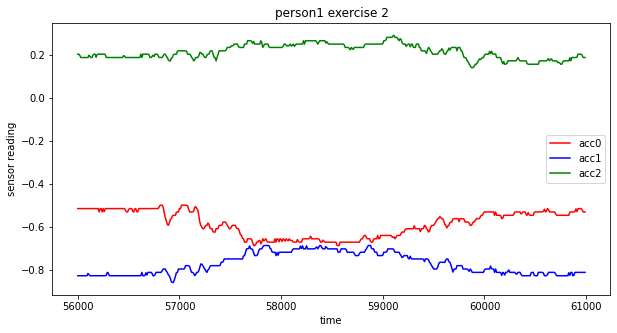

In [10]:
#p1_2 vis
def vis(df, idx, title):
  plt.figure(figsize=(10, 5))
  plt.plot(df['df'].iloc[idx]['time'], df['df'].iloc[idx]['acc_0'], color= 'red', label = 'acc0')
  plt.plot(df['df'].iloc[idx]['time'], df['df'].iloc[idx]['acc_1'], color = 'blue', label = 'acc1')
  plt.plot(df['df'].iloc[idx]['time'], df['df'].iloc[idx]['acc_2'], color = 'green', label = 'acc2')
  plt.xlabel('time')
  plt.ylabel('sensor reading')
  plt.title(title)
  plt.legend()

vis(p1_2, idx1, 'person1 exercise 2')


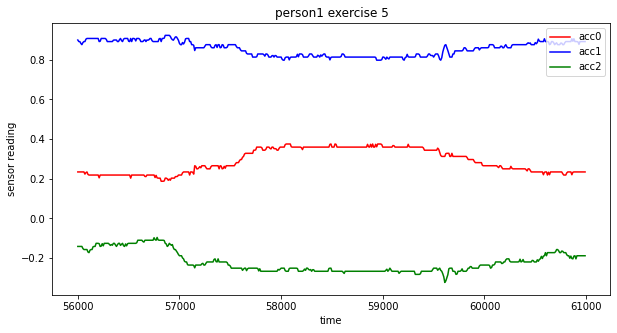

In [11]:
idx1, idx2 = idx(p1_5)
vis(p1_5, idx1, 'person1 exercise 5')

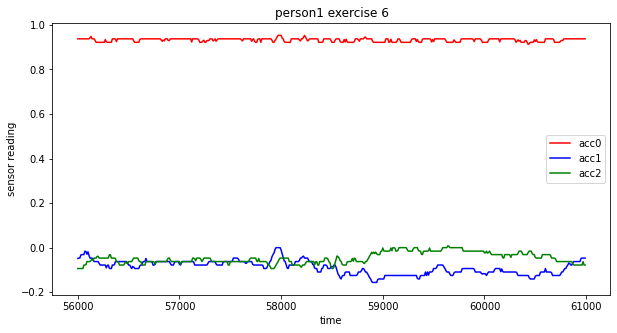

In [12]:
idx1, idx2 = idx(p1_6)
vis(p1_6, idx1, 'person1 exercise 6')

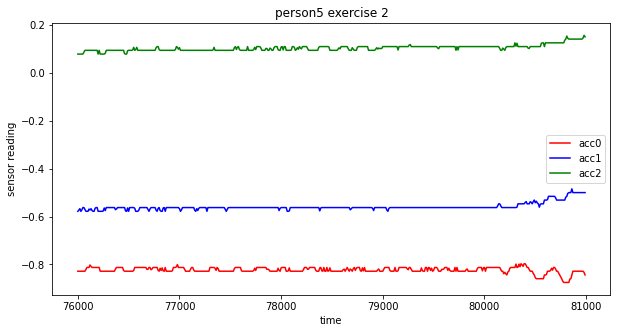

In [13]:
idx1, idx2 = idx(p5_2)
vis(p5_2, idx1, 'person5 exercise 2')

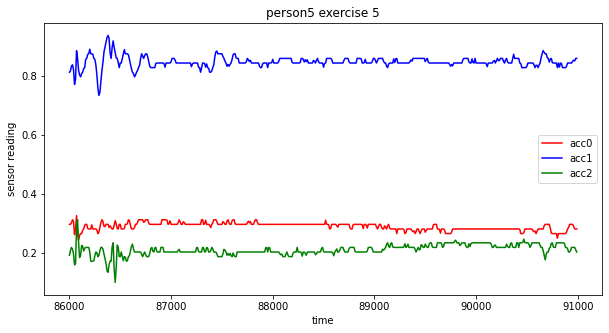

In [14]:
idx1, idx2 = idx(p5_5)
vis(p5_5, idx1, 'person5 exercise 5')

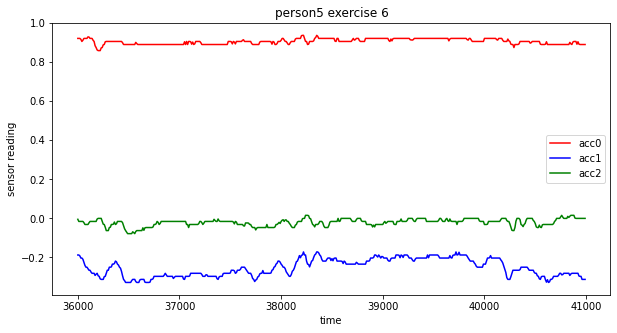

In [15]:
idx1, idx2 = idx(p5_6)
vis(p5_6, idx1, 'person5 exercise 6')

## 1.1 Depth camera data visualisation

In [16]:
p1_2['df'].iloc[idx2].head(10)

,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,...,dc_152,dc_153,dc_154,dc_155,dc_156,dc_157,dc_158,dc_159,dc_160,dc_161,dc_162,dc_163,dc_164,dc_165,dc_166,dc_167,dc_168,dc_169,dc_170,dc_171,dc_172,dc_173,dc_174,dc_175,dc_176,dc_177,dc_178,dc_179,dc_180,dc_181,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
36,36000.0,0.4614,0.9337,0.9314,0.9275,0.9243,0.9212,0.9204,0.9181,0.9165,0.9099,0.9087,0.9041,0.8986,0.8994,0.8971,0.8994,0.4637,0.9329,0.9352,0.8261,0.9298,0.9243,0.9243,0.9212,0.9181,0.915,0.9087,0.9048,0.4474,0.4257,0.2240,0.8994,0.4528,0.6987,0.8534,0.8319,0.7605,0.7520,0.9197,...,0.9470,0.4719,0.0000,0.5901,0.5653,0.5517,0.0000,0.9306,0.482,0.961,0.9680,0.9633,0.8775,0.961,0.9571,0.9501,0.9501,0.9470,0.947,0.9438,0.9438,0.9387,0.9387,0.9368,0.4855,0.9688,0.9711,0.9695,0.9641,0.961,0.9571,0.9571,0.954,0.7145,0.9501,0.947,0.9446,0.9470,0.9407,0.9378
37,37000.0,0.4606,0.9337,0.9322,0.9275,0.9251,0.9212,0.9212,0.9181,0.9150,0.9093,0.9087,0.9048,0.8986,0.8994,0.8971,0.8994,0.4637,0.9337,0.9345,0.8297,0.9298,0.9251,0.9243,0.9212,0.9181,0.915,0.9093,0.9048,0.2256,0.5636,0.8994,0.9017,0.4536,0.6987,0.8534,0.8294,0.7658,0.7582,0.9189,...,0.9470,0.9470,0.9470,0.6045,0.5758,0.5640,0.0000,0.9306,0.482,0.961,0.9688,0.9610,0.8791,0.961,0.9571,0.9501,0.9501,0.9478,0.947,0.9446,0.9438,0.9387,0.9407,0.9368,0.4855,0.9680,0.9711,0.9695,0.9641,0.961,0.9571,0.9571,0.954,0.9283,0.9486,0.947,0.9446,0.9470,0.9407,0.9378
38,38000.0,0.4606,0.9337,0.9314,0.9275,0.9259,0.9212,0.9212,0.9181,0.9150,0.9093,0.9087,0.9041,0.8986,0.8994,0.8971,0.8994,0.4637,0.9322,0.9352,0.8358,0.9283,0.9251,0.9235,0.9212,0.9181,0.915,0.9087,0.9056,0.0000,0.5638,0.8994,0.8994,0.4528,0.6980,0.8518,0.8370,0.7744,0.7761,0.9189,...,0.9470,0.9470,0.9454,0.4573,0.5774,0.5640,0.0000,0.9306,0.482,0.961,0.9688,0.9610,0.8815,0.961,0.9571,0.9501,0.9501,0.9470,0.947,0.9446,0.9438,0.9387,0.9397,0.9368,0.4855,0.9680,0.9711,0.9703,0.9641,0.961,0.9571,0.9571,0.954,0.7126,0.9501,0.947,0.9470,0.9462,0.9407,0.9368
39,39000.0,0.4606,0.9337,0.9314,0.9275,0.9243,0.9212,0.9212,0.9181,0.9150,0.9093,0.9087,0.9041,0.8986,0.8994,0.8971,0.8994,0.4622,0.9337,0.9345,0.8350,0.9283,0.9251,0.9235,0.9212,0.9181,0.915,0.9087,0.9041,0.8955,0.4520,0.8994,0.8994,0.4528,0.9306,0.8534,0.8364,0.7721,0.7652,0.9197,...,0.9470,0.9470,0.9470,0.1531,0.5801,0.5696,0.9337,0.9314,0.482,0.961,0.9688,0.9633,0.8799,0.961,0.9571,0.9501,0.9501,0.9470,0.947,0.9446,0.9438,0.9387,0.9407,0.9368,0.4855,0.9680,0.9711,0.9695,0.9641,0.961,0.9571,0.9571,0.954,0.9288,0.9470,0.947,0.9438,0.9470,0.9407,0.9387
40,40000.0,0.4606,0.9337,0.9329,0.9275,0.9243,0.9212,0.9204,0.9181,0.9150,0.9093,0.9087,0.9041,0.8986,0.8994,0.8971,0.8994,0.4637,0.9329,0.9352,0.8311,0.9290,0.9251,0.9235,0.9212,0.9181,0.915,0.9093,0.9041,0.6730,0.5733,0.9002,0.9009,0.4528,0.6987,0.8534,0.8331,0.7664,0.7566,0.9197,...,0.7118,0.2367,0.4719,0.5942,0.5679,0.5531,0.5628,0.9306,0.482,0.961,0.9688,0.9626,0.8727,0.961,0.9563,0.9501,0.9501,0.9478,0.947,0.9438,0.9438,0.9368,0.9407,0.9352,0.4855,0.9688,0.9721,0.9695,0.9641,0.961,0.9571,0.9571,0.954,0.7155,0.9470,0.947,0.9454,0.9462,0.9415,0.9387


Text(0.5, 1.0, 'Depth Camera Person 1 Activity 2')

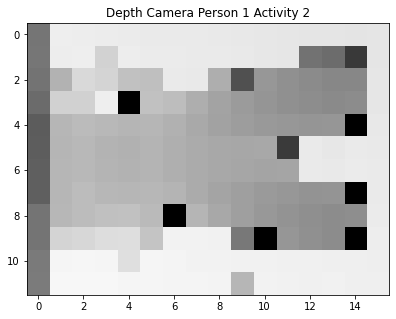

In [17]:
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p1_2['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 1 Activity 2')


Text(0.5, 1.0, 'Depth Camera Person 1 Activity 5')

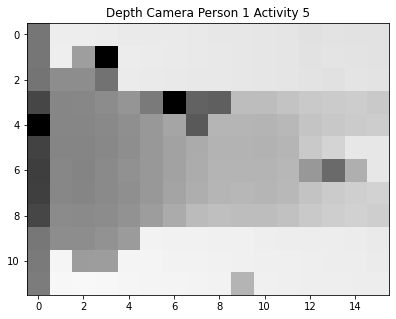

In [18]:
#Person 1 Activity 5

idx1, idx2 = idx(p1_5)
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p1_5['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 1 Activity 5')

Text(0.5, 1.0, 'Depth Camera Person 1 Activity 6')

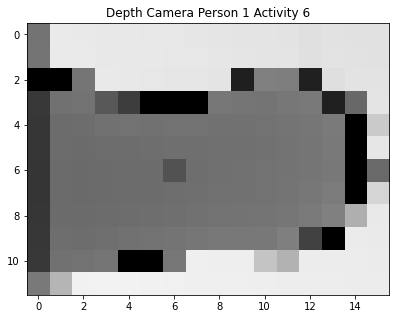

In [19]:
#Person 1 Activity 6

idx1, idx2 = idx(p1_6)
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p1_6['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 1 Activity 6')

Text(0.5, 1.0, 'Depth Camera Person 5 Activity 2')

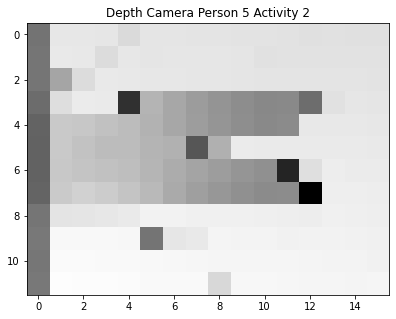

In [20]:
#Person 5 Activity 2
idx1, idx2 = idx(p5_2)
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p5_2['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 5 Activity 2')

Text(0.5, 1.0, 'Depth Camera Person 5 Activity 5')

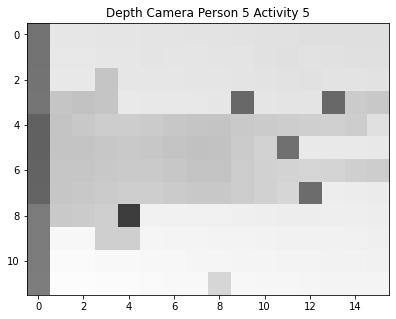

In [21]:
#Person 5 Activity 5

idx1, idx2 = idx(p5_5)
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p5_5['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 5 Activity 5')

Text(0.5, 1.0, 'Depth Camera Person 5 Activity 6')

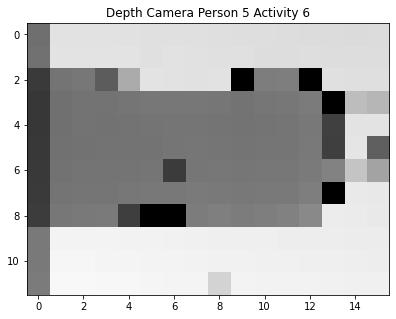

In [22]:
#Person 5 Activity 6

idx1, idx2 = idx(p5_6)
plt.figure(figsize=(10, 5))
from PIL import Image
temp_image = p5_6['df'].iloc[idx2].drop('time', axis=1)
image = temp_image[temp_image.columns].values[0]
image = image.reshape(12, 16)
img = Image.fromarray((image * 255.0).astype('uint8'), mode='P')
plt.imshow(img)
plt.title('Depth Camera Person 5 Activity 6')

## 1.2 Train Test Split

In [23]:
test = df_records_windowed[(df_records_windowed['subject_id'] == '08') |
                           (df_records_windowed['subject_id'] == '09') |
                           (df_records_windowed['subject_id'] == '10')]


In [24]:
train = df_records_windowed.drop(test.index)


In [92]:
print('df_records: ', len(df_records))
print('df_records_windowed: ',len(df_records_windowed))
print('test: ',len(test))
print('train: ',len(train))

df_records:  160
df_records_windowed:  4169
test:  1196
train:  2973


# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 23-24) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.
    
</div>

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy import signal
from sklearn import metrics
scaler = StandardScaler()

In [29]:
train_acc = train[train['sensor'] == 'acc']
train_dc = train[train['sensor'] == 'dc']
test_acc = test[test['sensor'] == 'acc']
test_dc = test[test['sensor'] == 'dc']

In [30]:
#Dropping last window in acc training set
train_acc.drop(train_acc.tail(1).index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Dropping time column

In [31]:
for i in range(len(train_acc['df'])):
  train_acc['df'].iloc[i].drop('time', axis=1, inplace=True)

train_acc['df'].iloc[0].head()

,acc_0,acc_1,acc_2
0,-0.039062,0.0,-0.984375
1,-0.039062,0.0,-0.984375
2,-0.031250,0.0,-0.984375
3,-0.031250,0.0,-0.984375
4,-0.031250,0.0,-0.984375


In [32]:
for i in range(len(test_acc['df'])):
  test_acc['df'].iloc[i].drop('time', axis=1, inplace=True)


In [33]:
for i in range(len(train_dc['df'])):
  train_dc['df'].iloc[i].drop('time', axis=1, inplace=True)


In [34]:
for i in range(len(test_dc['df'])):
  test_dc['df'].iloc[i].drop('time', axis=1, inplace=True)


## 2.1 Accelerometer PCA & LDA Fusion


In [35]:
# 2.1

### Your code begins here ###


#n_components cannot be larger than min(n_features, n_classes - 1) >> lda
#n_components cannot be larger than min (n_features, num_samples) >> pca
from scipy import stats
a = signal.resample(train_acc['df'].iloc[0], 125)
a = a.reshape(3, 125)
a = stats.zscore(a)
a = pd.DataFrame(a)
a['target'] = train_acc.iloc[0]['exercise_id']

b = signal.resample(train_acc['df'].iloc[1], 125)
b = b.reshape(3, 125)
b = stats.zscore(b)
b = pd.DataFrame(b)
b['target'] = train_acc.iloc[1]['exercise_id']

train_acc_df = pd.concat([a, b], axis=0)

for i in range(2, len(train_acc['df'])):
  #print(i)
  x = signal.resample(train_acc['df'].iloc[i], 125)
  x = x.reshape(3, 125)
  x = stats.zscore(x)
  x = pd.DataFrame(x)
  x['target'] = train_acc.iloc[i]['exercise_id']
  train_acc_df = pd.concat([train_acc_df, x], axis=0)

##########################################################################
a = signal.resample(test_acc['df'].iloc[0], 125)
a = a.reshape(3, 125)
a = stats.zscore(a)
a = pd.DataFrame(a)
a['target'] = test_acc.iloc[0]['exercise_id']

b = signal.resample(test_acc['df'].iloc[1], 125)
b = b.reshape(3, 125)
b = stats.zscore(b)
b = pd.DataFrame(b)
b['target'] = test_acc.iloc[1]['exercise_id']

test_acc_df = pd.concat([a, b], axis=0)

for i in range(2, len(test_acc['df'])):
  #print(i)
  x = signal.resample(test_acc['df'].iloc[i], 125)
  x = x.reshape(3, 125)
  x = stats.zscore(x)
  x = pd.DataFrame(x)
  x['target'] = test_acc.iloc[i]['exercise_id']
  test_acc_df = pd.concat([test_acc_df, x], axis=0)  


pca = PCA(n_components = 5) 
lda = LinearDiscriminantAnalysis(n_components = 5)
pca_train = pca.fit_transform(train_acc_df.drop('target', axis=1))
components = pca.components_ 
lda_train = lda.fit_transform(train_acc_df.drop('target', axis=1), train_acc_df['target'])
pca_test = pca.transform(test_acc_df.drop('target', axis=1))
lda_test = lda.transform(test_acc_df.drop('target', axis=1))

print(len(pca_train))
print(len(pca_test))

4458
1794


In [36]:
train_acc_df.shape

(4458, 126)

In [37]:
#Flattening the 3 channels in PCA & LDA

pca_train_flattened = []
for i in range(0, len(pca_train), 3):
  pca_train_flattened.append(list(pca_train[i]) + list(pca_train[i+1]) + list(pca_train[i+2]))

lda_train_flattened = []
for i in range(0, len(lda_train), 3):
  lda_train_flattened.append(list(lda_train[i]) + list(lda_train[i+1]) + list(lda_train[i+2]))

pca_test_flattened = []
for i in range(0, len(pca_test), 3):
  pca_test_flattened.append(list(pca_test[i]) + list(pca_test[i+1]) + list(pca_test[i+2]))

lda_test_flattened = []
for i in range(0, len(lda_test), 3):
  lda_test_flattened.append(list(lda_test[i]) + list(lda_test[i+1]) + list(lda_test[i+2]))

In [38]:
pca_res_ex = []
pca_res = []
for i in range(len(pca_test_flattened)):
  pca_res_ex = np.power(np.array(pca_test_flattened[i]) - np.array(pca_train_flattened), 2)
  
  pca_res.append(np.sum(pca_res_ex, axis = 1))

In [39]:
lda_res_ex = []
lda_res = []
for i in range(len(lda_test_flattened)):

  lda_res_ex = np.power(np.array(lda_test_flattened[i]) - np.array(lda_train_flattened), 2)
  lda_res.append(np.sum(lda_res_ex, axis = 1))



In [40]:
from sklearn.preprocessing import minmax_scale 
pca_norm = minmax_scale(pca_res, feature_range=(0, 1), axis= 1, copy=True)
lda_norm = minmax_scale(lda_res, feature_range=(0, 1), axis= 1, copy=True)

pca_norm = pd.DataFrame(pca_norm)
lda_norm = pd.DataFrame(lda_norm)

lda_pca = pd.DataFrame(pca_norm)
lda_pca = (pca_norm + lda_norm) / 2


In [41]:
##Acc Target Train
train_target_acc = []
for i in range(0, len(train_acc_df), 3):
  train_target_acc.append(train_acc_df['target'].iloc[i])

train_target_acc = pd.DataFrame(train_target_acc)

test_target_acc = []

##Acc Target Test
for i in range(0, len(test_acc_df), 3):
  test_target_acc.append(test_acc_df['target'].iloc[i])

test_target_acc = pd.DataFrame(test_target_acc)


In [42]:
target_pca_lda = []
label_pca_lda = []

for i in range(len(lda_pca)):

  t = np.argmin(lda_pca.iloc[i])
  target_pca_lda.append(train_target_acc.iloc[t][0])
  label_pca_lda.append(test_target_acc.iloc[i][0])




In [43]:
label = pd.DataFrame(label_pca_lda)
target = pd.DataFrame(target_pca_lda)

F1 score:  [0.16129032 0.30769231 0.34042553 0.56756757 0.60377358 0.39593909
 0.33103448]
Confusion matrix: 



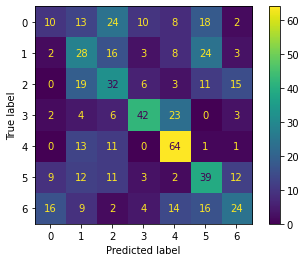

In [44]:
print("F1 score: ", metrics.f1_score(label, target, average=None))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(label, target)
metrics.ConfusionMatrixDisplay(cm).plot()

### Your code ends here ###

## DC


In [47]:
# 2.2

### Your code begins here ###


#Train
a = stats.zscore(train_dc['df'].iloc[0], axis = 1)
a = pd.DataFrame(a)
a['target'] = train_dc.iloc[0]['exercise_id']

b = stats.zscore(train_dc['df'].iloc[1], axis = 1)
b = pd.DataFrame(b)
b['target'] = train_dc.iloc[1]['exercise_id']

train_dc_df = pd.concat([a, b], axis=0)

for i in range(2, len(train_dc['df'])):
  
  x = stats.zscore(train_dc['df'].iloc[i], axis = 1)
  x = pd.DataFrame(x)
  x['target'] = train_dc.iloc[i]['exercise_id']
  train_dc_df = pd.concat([train_dc_df, x], axis=0)

#Test
a = stats.zscore(test_dc['df'].iloc[0], axis = 1)

a = pd.DataFrame(a)
a['target'] = test_dc.iloc[0]['exercise_id']

b = stats.zscore(test_dc['df'].iloc[1], axis = 1)
b = pd.DataFrame(b)
b['target'] = test_dc.iloc[1]['exercise_id']

test_dc_df = pd.concat([a, b], axis=0)

for i in range(2, len(test_dc['df'])):
  
  x = stats.zscore(test_dc['df'].iloc[i], axis = 1)

  x = pd.DataFrame(x)
  x['target'] = test_dc.iloc[i]['exercise_id']
  test_dc_df = pd.concat([test_dc_df, x], axis=0)

pca = PCA(n_components = 5) 
lda = LinearDiscriminantAnalysis(n_components = 5)
pca_train = pca.fit_transform(train_dc_df.drop('target', axis=1))
components = pca.components_ 
lda_train = lda.fit_transform(train_dc_df.drop('target', axis=1), train_dc_df['target'])
pca_test = pca.transform(test_dc_df.drop('target', axis=1))
lda_test = lda.transform(test_dc_df.drop('target', axis=1))

### Your code ends here ###

print(len(pca_train))
print(len(pca_test))

7430
2990


In [48]:
pca_train_flattened = []
for i in range(0, len(pca_train), 5):
  pca_train_flattened.append(list(pca_train[i]) + list(pca_train[i+1]) + list(pca_train[i+2] + list(pca_train[i+3]) + list(pca_train[i+4])))

lda_train_flattened = []
for i in range(0, len(lda_train), 5):
  lda_train_flattened.append(list(lda_train[i]) + list(lda_train[i+1]) + list(lda_train[i+2] + list(lda_train[i+3]) + list(lda_train[i+4])))

pca_test_flattened = []
for i in range(0, len(pca_test), 5):
  pca_test_flattened.append(list(pca_test[i]) + list(pca_test[i+1]) + list(pca_test[i+2]  + list(pca_test[i+3]) + list(pca_test[i+4])))

lda_test_flattened = []
for i in range(0, len(lda_test), 5):
  lda_test_flattened.append(list(lda_test[i]) + list(lda_test[i+1]) + list(lda_test[i+2] + list(lda_test[i+3]) + list(lda_test[i+4])))

In [49]:
pca_res_ex = []
pca_res = []
for i in range(len(pca_test_flattened)):
  pca_res_ex = np.power(np.array(pca_test_flattened[i]) - np.array(pca_train_flattened), 2)
  
  pca_res.append(np.sum(pca_res_ex, axis = 1))
  

In [50]:
lda_res_ex = []
lda_res = []
for i in range(len(lda_test_flattened)):

  lda_res_ex = np.power(np.array(lda_test_flattened[i]) - np.array(lda_train_flattened), 2)
  lda_res.append(np.sum(lda_res_ex, axis = 1))



In [51]:
from sklearn.preprocessing import minmax_scale 
pca_norm = minmax_scale(pca_res, feature_range=(0, 1), axis= 1, copy=True)
lda_norm = minmax_scale(lda_res, feature_range=(0, 1), axis= 1, copy=True)

pca_norm = pd.DataFrame(pca_norm)
lda_norm = pd.DataFrame(lda_norm)

lda_pca = pd.DataFrame(pca_norm)
lda_pca = (pca_norm + lda_norm) / 2
#pd.DataFrame(pca_norm)

In [52]:
##Target Train
train_target_dc = []
for i in range(0, len(train_dc_df), 5):
  train_target_dc.append(train_dc_df['target'].iloc[i])

train_target_dc = pd.DataFrame(train_target_dc)

test_target_dc = []

##Target Test
for i in range(0, len(test_dc_df), 5):
  test_target_dc.append(test_dc_df['target'].iloc[i])

test_target_dc = pd.DataFrame(test_target_dc)

In [53]:
target_pca_lda = []
label_pca_lda = []

for i in range(len(lda_pca)):

  t = np.argmin(lda_pca.iloc[i])
  target_pca_lda.append(train_target_dc.iloc[t][0])
  label_pca_lda.append(test_target_dc.iloc[i][0])




In [54]:
label = pd.DataFrame(label_pca_lda)
target = pd.DataFrame(target_pca_lda)

### DC



F1 score:  [0.57028112 0.47727273 0.13445378 0.71428571 1.         0.4957265
 0.74235808]
Confusion matrix: 



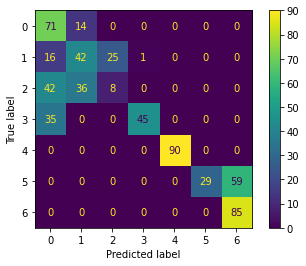

In [55]:

print("F1 score: ", metrics.f1_score(label,target,average=None))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(label, target)
metrics.ConfusionMatrixDisplay(cm).plot()

### Your code ends here ###

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   
<br> 
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>  
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br> 
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

# 3.1 Concatenating Acc channels (36-dim)


In [58]:
# 3.1

### Your code begins here ###
train_acc_df['mean'] = np.mean(train_acc_df.drop('target', axis=1), axis=1)
test_acc_df['mean'] = np.mean(test_acc_df.drop('target', axis=1), axis=1)
train_acc_df['std'] = np.std(train_acc_df.drop('target', axis=1), axis=1)
test_acc_df['std'] = np.std(test_acc_df.drop('target', axis=1), axis=1)
#len(test_acc_df['std'])
#train_acc_df.drop('target', axis=1)

In [59]:
train_acc_df['mean'].reset_index().drop('index', axis=1, inplace=True)
test_acc_df['mean'].reset_index().drop('index', axis=1, inplace=True)
train_acc_df['std'].reset_index().drop('index', axis=1, inplace=True)
test_acc_df['std'].reset_index().drop('index', axis=1, inplace=True)

In [60]:
pca = PCA(n_components = 10) 
pca_train = pca.fit_transform(train_acc_df.drop(['mean', 'std', 'target'], axis=1))
pca_test = pca.transform(test_acc_df.drop(['mean', 'std', 'target'], axis=1))

print(len(pca_train))
print(len(pca_train[0]))

4458
10


In [61]:
pca_train = pd.DataFrame(pca_train)
pca_test = pd.DataFrame(pca_test)

In [62]:
pca_train['mean'] = train_acc_df['mean'].values
pca_train['std'] = train_acc_df['std'].values
pca_test['mean'] = test_acc_df['mean'].values
pca_test['std'] = test_acc_df['std'].values


In [63]:
#Acc train 36-dim concat vector 
pca_train_concat_acc = []
for i in range(0, len(pca_train), 3):
  pca_train_concat_acc.append(np.concatenate([pca_train.iloc[i], pca_train.iloc[i+1], pca_train.iloc[i+2]], axis=0))

#pd.DataFrame(pca_train_concat_acc)

In [64]:
#Acc Test 36-dim concat vector 
pca_test_concat_acc = []
for i in range(0, len(pca_test), 3):
  pca_test_concat_acc.append(np.concatenate([pca_test.iloc[i], pca_test.iloc[i+1], pca_test.iloc[i+2]], axis=0))
  
len(pca_test_concat_acc[0])


36

In [65]:
df_acc_vector_train = pd.DataFrame(pca_train_concat_acc)
df_acc_vector_test = pd.DataFrame(pca_test_concat_acc)

### Your code ends here ###


# 3.2 Concatenating DC channels (50-dim)


In [66]:
# 3.2

### Your code begins here ###
pca = PCA(n_components = 10) 
pca_train_dc = pca.fit_transform(train_dc_df.drop(['target'], axis=1))
pca_test_dc = pca.transform(test_dc_df.drop(['target'], axis=1))

print(len(pca_train_dc))
print(len(pca_train_dc[0]))
pca_train_dc = pd.DataFrame(pca_train_dc)
pca_test_dc = pd.DataFrame(pca_test_dc)
#pca_train_dc


7430
10


In [67]:
#PCA train 50-dim concat vector dc
pca_train_concat_dc = []
for i in range(0, len(pca_train_dc), 5):
  pca_train_concat_dc.append(np.concatenate([pca_train_dc.iloc[i], pca_train_dc.iloc[i+1], pca_train_dc.iloc[i+2], pca_train_dc.iloc[i+3], pca_train_dc.iloc[i+4]], axis=0))

len(pca_train_concat_dc[0])


50

In [68]:
#PCA test 50-dim concat vector dc
pca_test_concat_dc = []
for i in range(0, len(pca_test_dc), 5):
  pca_test_concat_dc.append(np.concatenate([pca_test_dc.iloc[i], pca_test_dc.iloc[i+1], pca_test_dc.iloc[i+2], pca_test_dc.iloc[i+3], pca_test_dc.iloc[i+4]], axis=0))

len(pca_test_concat_dc)

598

In [69]:
#Creating them as dataframes
df_dc_vector_train = pd.DataFrame(pca_train_concat_dc)
df_dc_vector_test = pd.DataFrame(pca_test_concat_dc)

len(df_dc_vector_train)


### Your code ends here ###

1486

# 3.3 Concatenating Acc & DC channels (86-dim)


In [70]:
# 3.3

### Your code begins here ###

#Concatenating acc and dc to 1486 x 86 dataframe
acc_dc_window_train_0 = np.concatenate([df_acc_vector_train.iloc[0], df_dc_vector_train.iloc[0]], axis=0)
acc_dc_window_train_0 = pd.DataFrame(acc_dc_window_train_0)
acc_dc_window_train_1 = np.concatenate([df_acc_vector_train.iloc[1], df_dc_vector_train.iloc[1]], axis=0)
acc_dc_window_train_1 = pd.DataFrame(acc_dc_window_train_1)

acc_dc_full_train = np.concatenate([acc_dc_window_train_0, acc_dc_window_train_1], axis=1)
acc_dc_full_train = pd.DataFrame(acc_dc_full_train)

for i in range(2, len(df_dc_vector_train)):
  acc_dc_window_train = np.concatenate([df_acc_vector_train.iloc[i], df_dc_vector_train.iloc[i]], axis=0)
  acc_dc_window_train = pd.DataFrame(acc_dc_window_train)
  acc_dc_full_train = pd.concat([acc_dc_full_train, acc_dc_window_train], axis=1)
  
acc_dc_full_train = acc_dc_full_train.transpose()

#acc_dc_full_train

In [71]:
#Concatenating into 598 x 86 dataframe that has acc and dc 
acc_dc_window_test_0 = pd.concat([df_acc_vector_test.iloc[0], df_dc_vector_test.iloc[0]], axis=0)
acc_dc_window_test_1 = pd.concat([df_acc_vector_test.iloc[1], df_dc_vector_test.iloc[1]], axis=0)

acc_dc_full_test = pd.concat([acc_dc_window_test_0, acc_dc_window_test_1], axis=1)

for i in range(2, len(df_dc_vector_test)):
  acc_dc_window_test = pd.concat([df_acc_vector_test.iloc[i], df_dc_vector_test.iloc[i]], axis=0)
  acc_dc_full_test = pd.concat([acc_dc_full_test, acc_dc_window_test], axis=1)
  
acc_dc_full_test = acc_dc_full_test.transpose()
#acc_dc_full_test


In [72]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler( )
# transform data


normalized_full_train = minmax_scale(acc_dc_full_train, feature_range=(0, 1), axis=1, copy=True)
normalized_full_test = minmax_scale(acc_dc_full_test, feature_range=(0, 1), axis=1, copy=True)

normalized_full_train = pd.DataFrame(normalized_full_train)
normalized_full_test = pd.DataFrame(normalized_full_test)


## 3.3 SVM (RBF Kernel)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 score:  [0.50236967 0.59090909 0.16513761 0.56164384 0.97142857 0.38709677
 0.63507109]
Confusion matrix: 



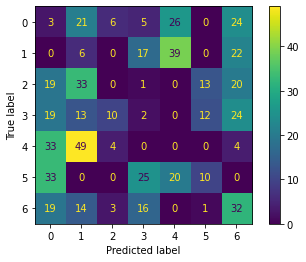

In [96]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(normalized_full_train, train_target_dc)

predicted= clf.predict(normalized_full_test)

print("F1 score: ", metrics.f1_score(test_target_dc,predicted,average=None))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(test_target_acc, predicted)
metrics.ConfusionMatrixDisplay(cm).plot()

### Your code ends here ###

## 3.3 Guassian Naive Bayes

F1 score:  [0.55223881 0.41148325 0.16455696 0.57711443 0.94117647 0.58064516
 0.46376812]
Confusion matrix: 



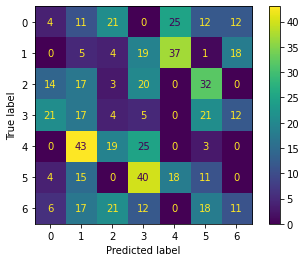

In [98]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(normalized_full_train, np.ravel(train_target_dc))

predicted= gnb.predict(normalized_full_test)

print("F1 score: ", metrics.f1_score(test_target_dc,predicted,average=None))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(test_target_acc, predicted)
metrics.ConfusionMatrixDisplay(cm).plot()

